<a href="https://colab.research.google.com/github/raffeekk/ML/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%203/assignment03_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Домашнее задание № 3. <br>Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

**В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья и (при желании) случайный лес в задаче классификации на данных Adult репозитория UCI.

Подключаем необходимые библиотеки

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Часть 1. Игрушечный набор данных "девушка в баре"

**Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.**

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**
<img src='https://github.com/raffeekk/ML/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%203/toy_data.png?raw=1'>

### Создание набора данных

In [ ]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [ ]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

**Обучающая выборка**

In [ ]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная']
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,False,True,True,False,True,False,False,False,True
1,1,False,True,True,False,False,True,False,True,False
2,0,False,True,False,True,False,False,True,False,True
3,1,True,False,False,True,False,False,True,True,False
4,1,True,False,True,False,False,True,False,False,True
5,0,True,False,True,False,True,False,False,False,True
6,0,False,True,True,False,False,False,True,False,True


**Тестовая выборка**

In [ ]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая']
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,False,True,False,True,False,True,False,True
1,False,True,True,False,True,False,True,False
2,True,False,True,False,False,True,False,True


In [ ]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Внешность_приятная,Алкоголь_в_напитке_да,Внешность_отталкивающая,Потраченные_деньги_много,Уровень_красноречия_высокий,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Уровень_красноречия_средний
0,True,True,False,True,True,False,False,False
1,True,True,False,False,False,False,True,False
2,True,False,False,True,False,True,False,True
3,False,False,True,False,False,True,True,True
4,False,True,True,True,False,False,False,False
5,False,True,True,True,True,False,False,False
6,True,True,False,True,False,False,False,True


In [ ]:
df_test

,Внешность_приятная,Алкоголь_в_напитке_да,Внешность_отталкивающая,Потраченные_деньги_много,Уровень_красноречия_высокий,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Уровень_красноречия_средний
0,True,False,False,True,False,True,False,True
1,True,True,False,False,True,False,True,False
2,False,True,True,True,False,False,False,True


**Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева.**

<font color='red'>Вопрос 1.</font> Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

<font color='red'>Вопрос 2. </font> Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)?

In [ ]:
# вопрос 1
# Функция для расчета энтропии
def entropy(y):
    """Вычисляет энтропию для массива меток."""
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

# Энтропия начальной системы S0
H_S0 = entropy(y)
print(f"Энтропия начальной системы S0: {H_S0}")

# вопрос 2
df_train = pd.DataFrame(df_train)

# Разбиение на группы
left_group = df_train[df_train['Внешность_приятная'] == 1]['Поедет']
right_group = df_train[df_train['Внешность_приятная'] == 0]['Поедет']

# Расчет энтропии для групп
H_S1 = entropy(left_group)
H_S2 = entropy(right_group)

# Прирост информации
n_total = len(df_train)
IG = H_S0 - (len(left_group) / n_total * H_S1 + len(right_group) / n_total * H_S2)

# Вывод результатов
print(f"Энтропия S1 (левая группа): {H_S1}")
print(f"Энтропия S2 (правая группа): {H_S2}")
print(f"Прирост информации IG: {IG}")


Энтропия начальной системы S0: 0.9852281360342515
Энтропия S1 (левая группа): 0.8112781244591328
Энтропия S2 (правая группа): 0.9182958340544896
Прирост информации IG: 0.12808527889139443


**Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.**

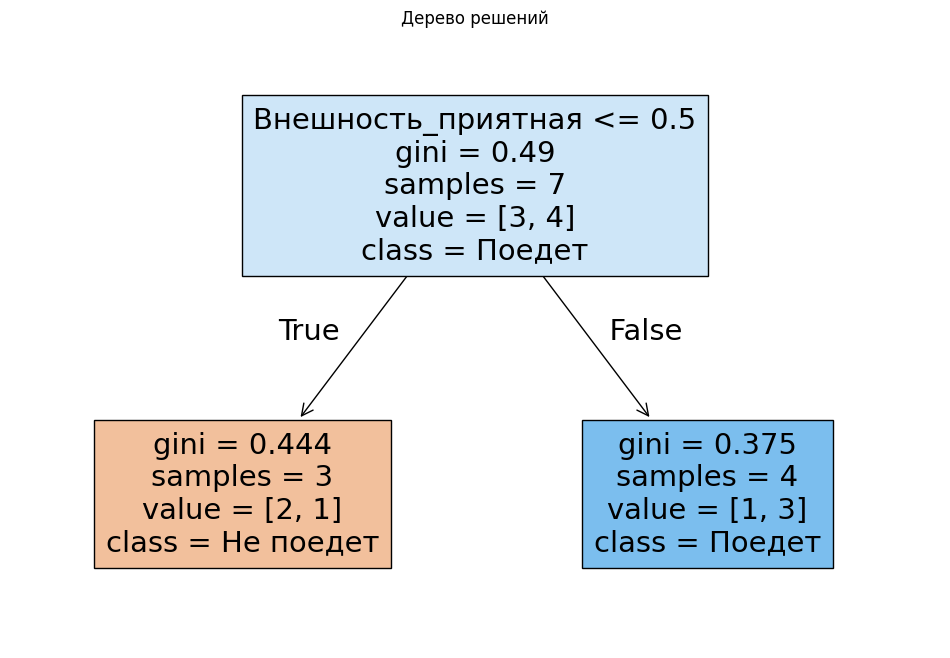

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Создание обучающих данных
X_train = df_train.drop(columns=['Поедет'])
y_train = df_train['Поедет']

# Инициализация и обучение модели дерева решений
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=['Не поедет', 'Поедет'], filled=True)
plt.title("Дерево решений")
plt.show()


**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

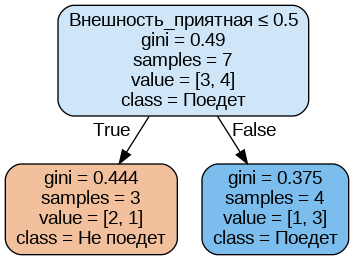

In [ ]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

# Экспорт дерева в формате DOT
export_graphviz(
    clf,
    out_file="tree.dot",
    feature_names=X_train.columns,
    class_names=["Не поедет", "Поедет"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Конвертация из DOT в PNG
(graph,) = pydot.graph_from_dot_file("tree.dot")
graph.write_png("tree.png")

# Отображение изображения
Image("tree.png")

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [ ]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](https://github.com/raffeekk/ML/blob/img/decision_tree3.png?raw=1)

Дальше пусть шарики разбиваются на 2 группы
![png](https://github.com/raffeekk/ML/blob/img/decision_tree4.png?raw=1)

In [ ]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [ ]:
def entropy(a_list):
    """
    Вычисляет энтропию Шеннона для списка значений.

    Args:
        a_list (list): Список элементов (например, метки классов).

    Returns:
        float: Энтропия Шеннона.
    """
    # Подсчитываем количество каждого уникального значения
    values, counts = np.unique(a_list, return_counts=True)

    # Вычисляем вероятности
    probabilities = counts / len(a_list)

    # Расчет энтропии по формуле H(S) = -Σ(p * log2(p))
    return -np.sum(probabilities * np.log2(probabilities))

Проверка

In [ ]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


<font color='red'>Вопрос 3.</font> Чему равна энтропия состояния, заданного списком `balls_left`?

In [ ]:
H_left = entropy(balls_left)
print(H_left)

0.9612366047228759


<font color='red'>Вопрос 4.</font> Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [ ]:
# расчет прироста информации

def information_gain(root, left, right):
    """
    Вычисляет прирост информации при разбиении данных на две группы.

    Args:
        root (list): Исходный набор данных.
        left (list): Левая группа после разбиения.
        right (list): Правая группа после разбиения.

    Returns:
        float: Прирост информации (IG).
    """
    # Размеры групп
    total = len(root)
    left_size = len(left)
    right_size = len(right)

    # Энтропии
    H_root = entropy(root)
    H_left = entropy(left)
    H_right = entropy(right)

    # Расчет IG
    IG = H_root - (left_size / total * H_left + right_size / total * H_right)
    return IG

    dice_probabilities = [1/6] * 6

H_dice = -np.sum([p * np.log2(p) for p in dice_probabilities])
print(f"Энтропия игральной кости: {H_dice}")

Энтропия игральной кости: 2.584962500721156


<font color='red'>Вопрос 5.  </font> Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [ ]:
# Общая выборка
balls = balls_left + balls_right

# Энтропия исходной выборки
H_root = entropy(balls)

# Энтропии левой и правой подвыборок
H_left = entropy(balls_left)
H_right = entropy(balls_right)

# Прирост информации
IG = H_root - (len(balls_left) / len(balls) * H_left + len(balls_right) / len(balls) * H_right)
print(f'Прирост информации: {IG:.4f}')

Прирост информации: 0.1609


**Опционально:**

 - реализуйте алгоритм построения дерева за счет рекурсивного вызова функции `best_feature_to_split`
 - нарисуйте полученное дерево

In [ ]:
def best_feature_to_split(X, y):
    """
    Выбирает лучший признак для разбиения по приросту информации.

    Args:
        X (DataFrame): Признаки.
        y (Series): Целевой признак (метки классов).

    Returns:
        int: Индекс лучшего признака.
    """
    best_ig = -float('inf')
    best_feature = -1

    # Проходим по всем признакам
    for feature in X.columns:
        values = X[feature]

        # Разделяем данные на 2 группы по уникальным значениям признака
        left = y[values == values.unique()[0]]
        right = y[values == values.unique()[1]]

        # Вычисляем прирост информации для каждого признака
        ig = information_gain(y, left, right)

        if ig > best_ig:
            best_ig = ig
            best_feature = feature

    return best_feature


## Часть 3. Набор данных "Adult"

**Описание набора:**

**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков:

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [73]:
a_train = "https://raw.githubusercontent.com/raffeekk/ML/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%203/adult_train.csv"
data_train = pd.read_csv(a_train, sep=';')

In [ ]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [72]:
a_test = "https://raw.githubusercontent.com/raffeekk/ML/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%203/adult_test.csv"
data_test = pd.read_csv(a_test, sep=';')

In [ ]:
new_var = data_test.tail()

In [ ]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.')
                      | (data_test['Target']==' <=50K.')]

# Перекодируем целевую переменную 'Target' в числовое поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первичный анализ данных.**

In [ ]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_train['Target'].value_counts()

,count
Target,
0,24720
1,7841


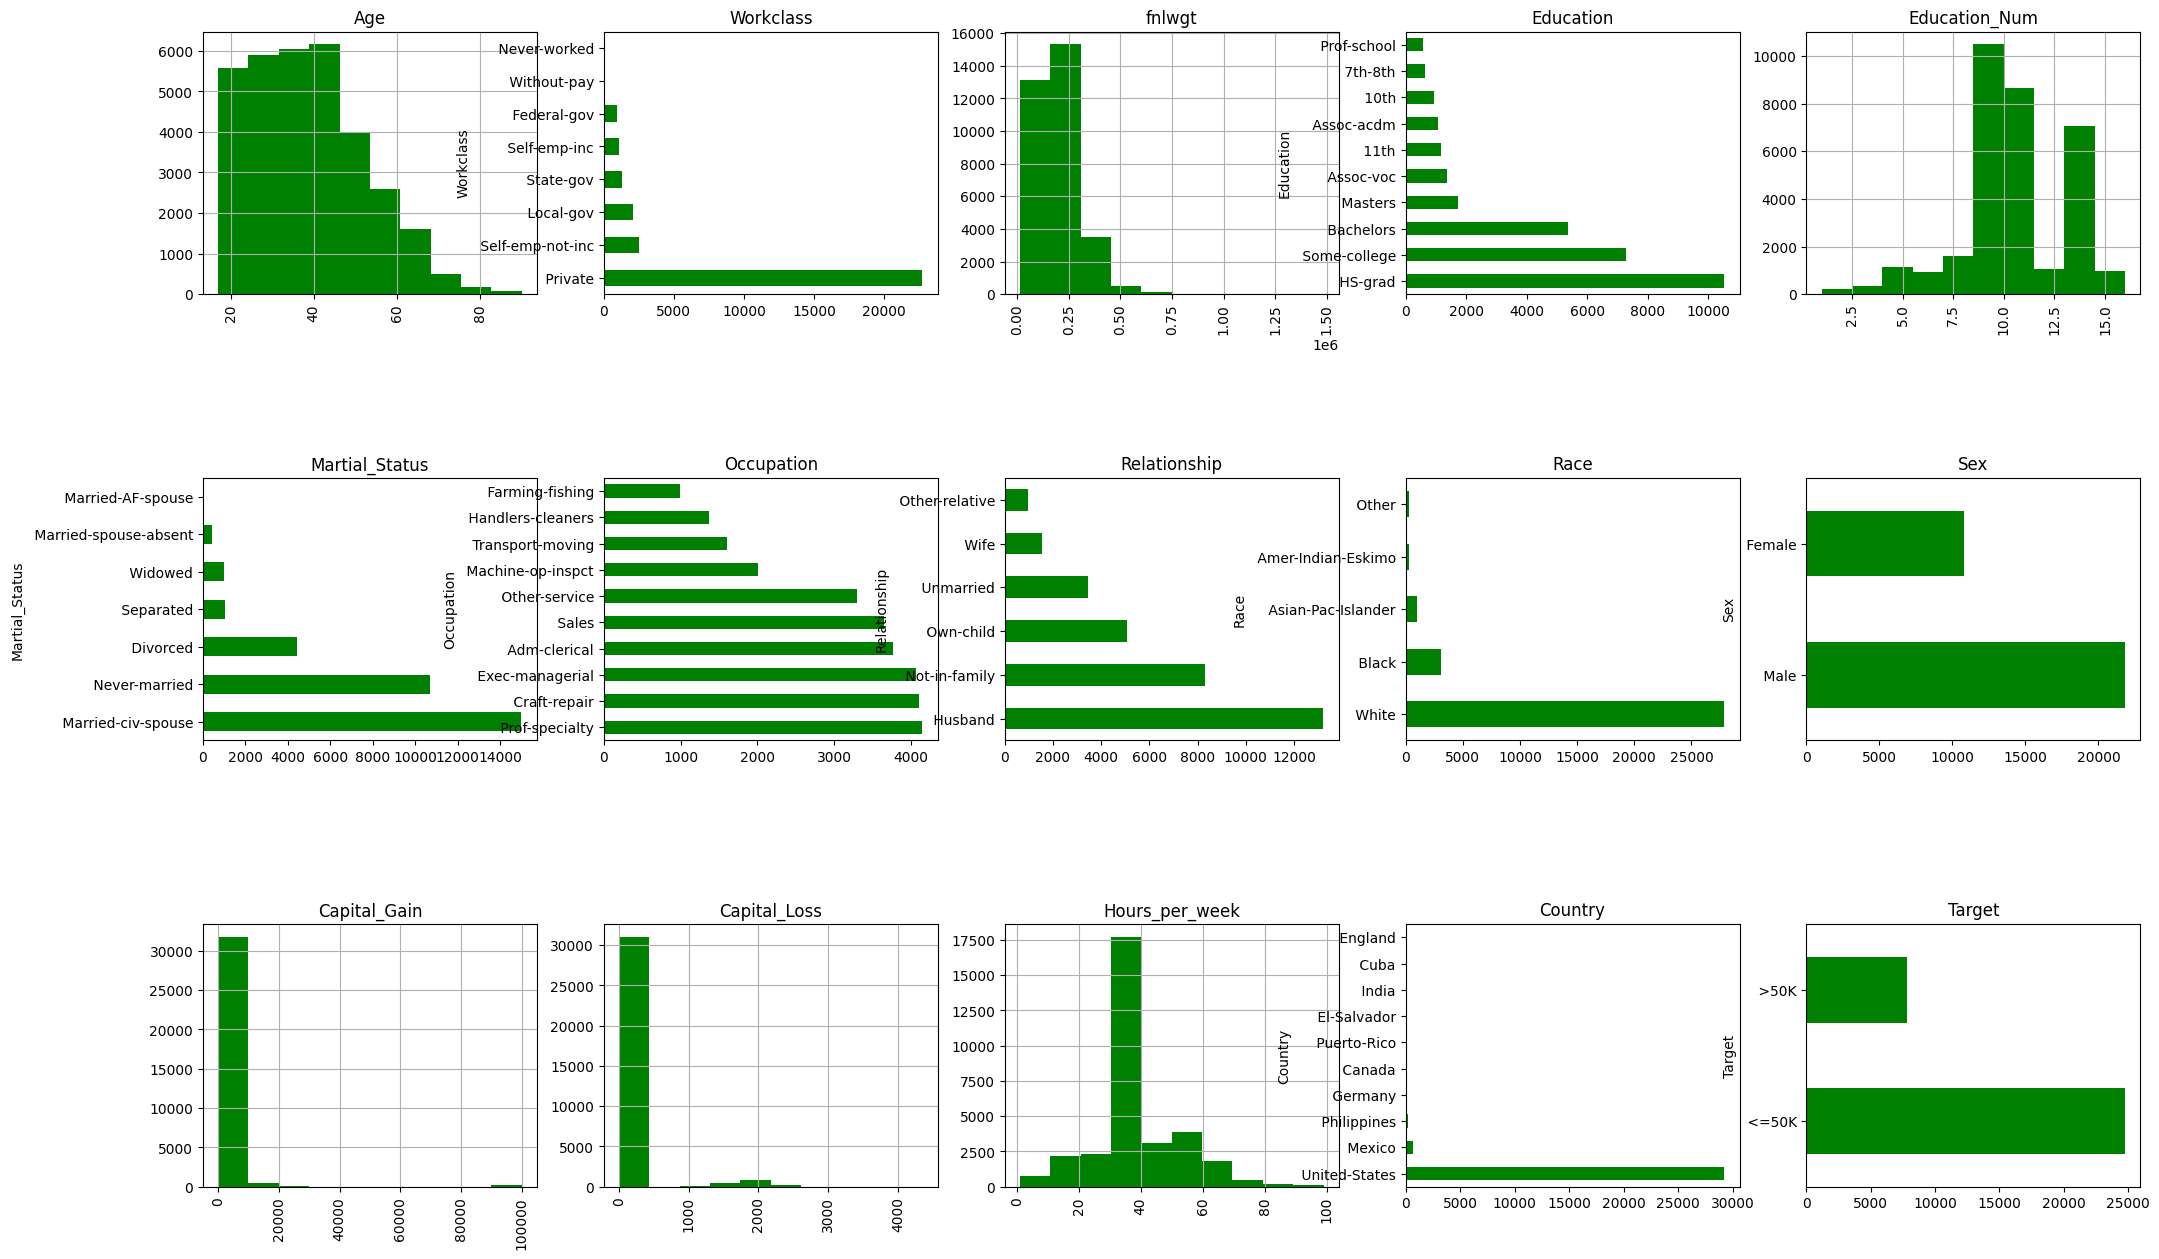

In [76]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))  # Приводим rows к целому числу

for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)

    # Для категориальных признаков
    if data_train[column].dtype == object:
        # Ограничиваем количество категорий (например, оставляем только 10 самых частых)
        top_categories = data_train[column].value_counts().nlargest(10)
        top_categories.plot(kind="barh", axes=ax, color='green')  # Горизонтальный бар-график с зеленым цветом
    else:
        # Для числовых признаков
        data_train[column].hist(axes=ax, color='green')  # Гистограмма с зеленым цветом
        plt.xticks(rotation="vertical")

plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

**Проверяем типы данных**

In [ ]:
data_train.dtypes

,0
Age,int64
Workclass,object
fnlwgt,int64
Education,object
Education_Num,int64
Martial_Status,object
Occupation,object
Relationship,object
Race,object
Sex,object


In [ ]:
data_test.dtypes

,0
Age,object
Workclass,object
fnlwgt,float64
Education,object
Education_Num,float64
Martial_Status,object
Occupation,object
Relationship,object
Race,object
Sex,object


Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [ ]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [ ]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [ ]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [ ]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())

for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())

<ipython-input-75-a4e84769ffda>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train[c] = data_train[c].fillna(data_train[c].mode())
<ipython-input-75-a4e84769ffda>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test[c] = data_test[c].fillna(data_train[c].mode())


**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [ ]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'],
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [ ]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation',
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [ ]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281.0,NaN,NaN,NaN,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,NaN,NaN,NaN,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,NaN,NaN,NaN,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...,...,...,...
Country_ Thailand,16281,2,False,16269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Trinadad&Tobago,16281,2,False,16273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ United-States,16281,2,True,14662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Vietnam,16281,2,False,16262,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [ ]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [ ]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [ ]:
set(data_train.columns) - set(data_test.columns)

set()

In [ ]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
2,38,89814,9,0,0,50,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0


In [ ]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 3.1. Дерево решений без настройки параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [ ]:
tree_predictions = tree.predict(X_test)

In [ ]:
# Оценка точности модели
accuracy_result = accuracy_score(y_test, tree_predictions)
print(f'Accuracy на тестовой выборке: {accuracy_result:.4f}')

Accuracy на тестовой выборке: 0.8448


<font color='red'>Вопрос 6.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

In [ ]:
# Выводим точность модели
print(f'Доля правильных ответов дерева решений: {accuracy_result:.4f}')


Доля правильных ответов дерева решений: 0.8448


## 3.2. Дерево решений с настройкой параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию**

In [ ]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(estimator=tree, param_grid=tree_params, cv=5)

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [ ]:
# Обучение дерева решений с максимальной глубиной 9
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
tuned_tree_predictions = tuned_tree.predict(X_test)

# Оценка точности модели на тестовой выборке
accuracy = accuracy_score(y_test, tuned_tree_predictions)

<font color='red'>Вопрос 7.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

In [ ]:
print(f'Accuracy на тестовой выборке: {accuracy:.4f}')

Accuracy на тестовой выборке: 0.8579


## 3.3. Случайный лес без настройки параметров  (опционально)¶

**Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья. **

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`), число деревьев сделайте равным ста, а `random_state` = 17.**

In [ ]:

rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [ ]:
forest_predictions = rf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, forest_predictions)

## 3.4. Случайный лес с настройкой параметров  (опционально)

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.**

In [ ]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = GridSearchCV # Ваш код здесь

locally_best_forest.fit # Ваш код здесь

<function sklearn.model_selection._search.BaseSearchCV.fit(self, X, y=None, **params)>

In [ ]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

AttributeError: type object 'GridSearchCV' has no attribute 'best_params_'

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [ ]:
tuned_forest_predictions = locally_best_forest.predict # Ваш код здесь
accuracy_score # Ваш код здесь

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>